#Классификация эссе на наличие лжи и правды с BOW ГЛЕБ

In [19]:
# Для нейросети
from config import Config
from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

import numpy as np # Для работы с данными 
import matplotlib.pyplot as plt # Для вывода графиков

import os # Для работы с файлами
%matplotlib inline

Функции для создания xTrain и xTest

In [20]:
# Формирование обучающей выборки по листу индексов слов
# путем разделения на короткие векторы
# wordIndexes - массив индексов
# xLen - размер окна
# step - шаг окна
def getSetFromIndexes(wordIndexes, xLen, step):
  xText = []
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen): # Идём по всей длине вектора индексов
    xText.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xText


# Формирование обучающей и проверочной выборки для каждого класса
# wordIndexes - массив индексов
# xLen - размер окна
# step - шаг окна
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна
  nClasses = len(wordIndexes) # Количество классов
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))

  # Формируем один общий xSamples
  xSamples = []
  ySamples = []
  
  for t in range(nClasses):
    xT = classesXSamples[t]
    for i in range(len(xT)): # Перебираем каждое окно определенного класса
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)

  
  return (xSamples, ySamples)

Загружаю файлы, которые содержат списки соответствующие текстам преобразованным в последовательности индексов согласно частотному словарю

Загрузив их мне нужно обработать их разными структурами нейросети BOW.

Результаты работы нейросети с разными параметрами я занесу в Excel.

Загрузка файлов позволяет не тратить время и ресурсы виртуальной среды на новую сборку датасета.

In [21]:
# Функция загрузки файлов
def loadList(filename):
    # the filename should mention the extension 'npy'
    tempNumpyArray=np.load(filename)
    return tempNumpyArray.tolist()

In [22]:
# Загрузка данных файлов в списки 
trainWordIndexes = np.load(Config.TRAIN_WORD_INDEXES_FILENAME, allow_pickle=True)
testWordIndexes = np.load(Config.TEST_WORD_INDEXES_FILENAME, allow_pickle=True)

In [23]:
# ЭТИ ПАРАМЕТРЫ МОЖНО И НУЖНО МЕНЯТЬ
# Задаём базовые параметры
xLen = 50 # Размер окна (количество слов в векторе)
step = 6 # Шаг разбиения текста на векторы

In [24]:
xTrainId, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTestId, yTest = createSetsMultiClasses(testWordIndexes, xLen, xLen)

# для каждого "окна" класса мы в соответствие ставим значение true или false => поэтому длины x и y одинаковые
print("Размерности тренировочного набора")
print(xTrainId.shape)
print(yTrain.shape)
print()
print("Размерности тестового набора")
print(xTestId.shape)
print(yTest.shape)

Размерности тренировочного набора
(67354, 50)
(67354, 2)

Размерности тестового набора
(872, 50)
(872, 2)


In [25]:
print(xTrainId[0])

[ 5748    69   652    16  8497  1554   223   249   381  3499     3  6461
    30   124   255   303   336 16379     2   313   233  2400  1258   120
    29   391    14     1    45 12534  4694     2  1324  8498    27  3733
   846   298 16380 12535 16381   820    85   194   164  5168     2 16382
  7346    66]


Преобразование в Bag Of words

In [26]:
numWords = 20000 # Количество слов/индексов, которое мы будем учитывать при обучении

# настраиваем токенайзер, все слова приводятся в нижний регистр, специальные символы опускаются
tokenizer = Tokenizer(num_words=numWords,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True,
                      split=' ',
                      oov_token='unknown',
                      char_level=False)

In [27]:
# Для модели BOW - преобразовываем в Bag Of Words
xTrain = tokenizer.sequences_to_matrix(xTrainId.tolist())
xTest  = tokenizer.sequences_to_matrix(xTestId.tolist())

In [28]:
# Формируем обучающую и тестовую выборку
xTrainId, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTestId, yTest = createSetsMultiClasses(testWordIndexes, xLen, xLen)
print("Размерности тренировочного набора")
print(xTrainId.shape)
print(yTrain.shape)
print()
print("Размерности тестового набора")
print(xTestId.shape)
print(yTest.shape)

Размерности тренировочного набора
(67354, 50)
(67354, 2)

Размерности тестового набора
(872, 50)
(872, 2)


Нейросеть для классификации текстов на базе Bag Of Words

In [29]:
# Создаём полносвязную сеть
model = Sequential()
model.add(Dense(512, input_dim=20000, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               10240512  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 10,241,538
Trainable params: 10,241,538
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Обучаем сеть
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2)

Epoch 1/10
842/842 [==============================] - 22s 26ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 9.1690 - val_accuracy: 0.2874
Epoch 2/10
842/842 [==============================] - 21s 25ms/step - loss: 2.0884e-06 - accuracy: 1.0000 - val_loss: 9.8430 - val_accuracy: 0.2874
Epoch 3/10
842/842 [==============================] - 22s 26ms/step - loss: 9.3469e-07 - accuracy: 1.0000 - val_loss: 10.3172 - val_accuracy: 0.2874
Epoch 4/10
842/842 [==============================] - 23s 27ms/step - loss: 5.1242e-07 - accuracy: 1.0000 - val_loss: 10.7062 - val_accuracy: 0.2874
Epoch 5/10
842/842 [==============================] - 24s 28ms/step - loss: 3.1155e-07 - accuracy: 1.0000 - val_loss: 11.0577 - val_accuracy: 0.2874
Epoch 6/10
842/842 [==============================] - 24s 29ms/step - loss: 1.9636e-07 - accuracy: 1.0000 - val_loss: 11.3908 - val_accuracy: 0.2874
Epoch 7/10
842/842 [==============================] - 26s 31ms/step - loss: 1.2327e-07 - accuracy: 1.0000 - val_

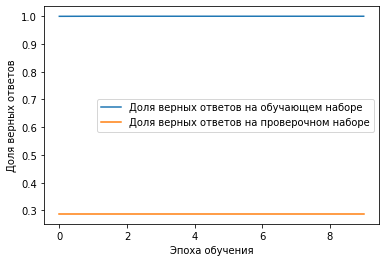

In [31]:
# При базовых параметрах =
# xLen = 500 # Размер окна (количество слов в векторе)
# step = 60 # Шаг разбиения текста на векторы
# Результат
# Epoch 10/10
# 157/157 [==============================] - 14s 90ms/step - loss: 1.4291e-07 - accuracy: 1.0000 - val_loss: 5.7179e-08 - val_accuracy: 1.0000
# Когда step < xLen, н.с. обучается значительно дольше
# Результат с новыми параметрами остался прежним

# Результаты обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Проверка работы обученной нейросети

In [32]:
# Проверка точности на тестовой выборке
rightAnswer = [0,0]
totalAnswer = [0,0]

# Получаем результаты распознавания для каждого класса
currPred = model.predict(xTest)
# Определяем номер распознанного класса для каждого вектора
currOut = np.argmax(currPred, axis=1)
# Определяем правильный класс для каждого вектора
yOut = np.argmax(yTest, axis=1)

print(currPred.shape)
print(currOut.shape)
print(yOut.shape)
print()

(872, 2)
(872,)
(872,)



In [36]:
# Подсчёт количества верных ответов
for i in range(len(yOut)):
  predictA = currOut[i]
  rightA   = yOut[i]

  totalAnswer[rightA] += 1
  if predictA == rightA:
    rightAnswer[rightA] += 1

print("Точность распознавания текстов")
for i in range(2):
  print("{:12s}: {:3d} из {:3d} - {:3.2f}%".format(str(i), rightAnswer[i], totalAnswer[i], (rightAnswer[i]/totalAnswer[i]*100)))

Точность распознавания текстов
0           : 812 из 812 - 100.00%
1           :   0 из 2676 - 0.00%
